# Experimenting with Chunk Optimization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from features.discursive_diversity import *
from functools import reduce

In [3]:
# this is in utils - copying here for ease of access lol
def preprocess_conversation_columns(df):
	# remove all special characters from df
	df.columns = df.columns.str.replace('[^A-Za-z0-9_]', '', regex=True)
	
	# If data is grouped by batch/round, add a conversation num
	if {'batch_num', 'round_num'}.issubset(df.columns):
		df['conversation_num'] = df.groupby(['batch_num', 'round_num']).ngroup()
		df = df[df.columns.tolist()[-1:] + df.columns.tolist()[0:-1]] # make the new column first

	return(df)

In [4]:
def reduce_chunks(num_rows, max_num_chunks):
    if (num_rows < max_num_chunks * 2):
        max_num_chunks = int(num_rows / 2)
    if max_num_chunks < 1:
        return 1
    else:
        return max_num_chunks
    

# Assign chunk numbers to the chats within each conversation
def assign_chunk_nums(chat_data, num_chunks):

    # Calculate the total number of rows per conversation
    conversation_lengths = chat_data.groupby('conversation_num').size()
    # num_conversations = chat_data['conversation_num'].nunique()

    chunks = conversation_lengths.apply(lambda x: reduce_chunks(x, num_chunks))

    # Calculate the chunk size based on the total number of conversations
    chunk_size = np.ceil(conversation_lengths / (chunks + 1)) # I found that using 10 in the bottom actually only generates 9 groups, so here I use 11 ... (weird)
    
    for i, group in chat_data.groupby('conversation_num'): # for each group
        chunk_num = 0
        counter = 0

        for chat_id in group.index.values: # iterate over the index values
            chat_data.at[chat_id, 'chunk_num'] = str(chunk_num)

            counter += 1

            #if counter = 1 for the last row of a group (implies last chunk has one element), and the chunk num > 0, then just make the last one - 1
            if counter == 1 and chunk_num > 0 and chat_id == group.index.values[-1]:
                chat_data.at[chat_id, 'chunk_num'] = str(chunk_num - 1)

            if counter == chunk_size[i] and chunk_num < chunks[i] - 1: # assign any extras to the last chunk
                chunk_num += 1
                counter = 0 
        
        
        # index = group.iloc[-1].index
        # chunk_num_last_row = int(chat_data.at[index, 'chunk_num'])
        # if counter == 1 and chunk_num_last_row > 0:
        #     chat_data.at[index, 'chunk_num'] = str(chunk_num_last_row - 1)
           

    return(chat_data)

In [5]:
def conv_to_float_arr(df):
    if isinstance(df['message_embedding'][0], str):
            df['message_embedding'] = [val[1:-1] for val in df['message_embedding']]
            df['message_embedding'] = [[float(e) for e in embedding.split(',')] for embedding in df['message_embedding']]
            df['message_embedding'] = [np.array(e) for e in df['message_embedding']]
    return df

In [6]:
def get_and_preprocess_chats(chat_path, vec_path):
    chat_data = pd.read_csv(chat_path)
    vec_data = pd.read_csv(vec_path)
    chat_data = preprocess_conversation_columns(chat_data)
    chat_data = pd.merge(chat_data, vec_data["message_embedding"], left_index=True, right_index=True)
    
    return chat_data, vec_data

In [7]:
def get_dd_results_by_chunk(chat_data):
    dd_results = chat_data.groupby(['conversation_num', 'chunk_num']).apply(get_DD)
    dd_results = dd_results.reset_index(drop=True)
    dd_results['chunk_num'] = dd_results.groupby('conversation_num').cumcount() + 1

    return(dd_results)

In [8]:
def plot_dd_results(dd_results):

    plt.figure(figsize=(12, 6))
    for conversation_num, group in dd_results.groupby('conversation_num'):
        plt.plot(group['chunk_num'], group['discursive_diversity'], label=f'Conversation {conversation_num}')

    plt.xlabel('Chunk Number (Each contains 10% of chats)')
    plt.ylabel('Discursive Diversity')
    plt.title('Discursive Diversity Over Time')
    plt.show()

In [10]:
#chat_juries, vect_juries = get_and_preprocess_chats("./data/raw_data/jury_conversations_with_outcome_var.csv", "./embeddings/jury_conversations_with_outcome_var.csv")

# checking tiny juries for testing!
chat_juries, vect_juries = get_and_preprocess_chats("./data/raw_data/juries_tiny_for_testing.csv", "./embeddings/juries_tiny_for_testing.csv")

chat_juries['message_embedding'] = conv_to_float_arr(chat_juries['message_embedding'].to_frame())


    conversation_num chunk_num
0                  0         0
1                  0         0
2                  0         0
3                  0         0
4                  0         0
5                  0         0
6                  0         0
7                  0         0
8                  0         0
9                  0         0
10                 0         0
11                 0         0
12                 0         0
13                 0         0
14                 0         0
15                 0         0
16                 0         0
17                 0         0
18                 0         1
19                 0         1
20                 0         1
21                 0         1
22                 0         1
23                 0         1
24                 0         1
25                 0         1
26                 0         1
27                 0         1
28                 0         1
29                 0         1
30                 0         1
31      

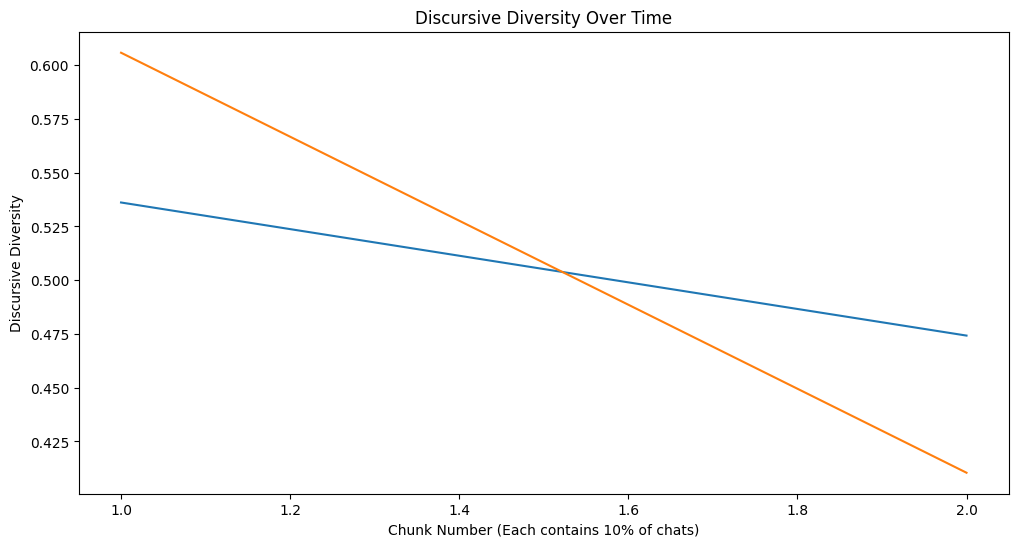

    conversation_num chunk_num
0                  0         0
1                  0         0
2                  0         0
3                  0         0
4                  0         0
5                  0         0
6                  0         0
7                  0         0
8                  0         0
9                  0         0
10                 0         0
11                 0         0
12                 0         0
13                 0         1
14                 0         1
15                 0         1
16                 0         1
17                 0         1
18                 0         1
19                 0         1
20                 0         1
21                 0         1
22                 0         1
23                 0         1
24                 0         1
25                 0         1
26                 0         2
27                 0         2
28                 0         2
29                 0         2
30                 0         2
31      

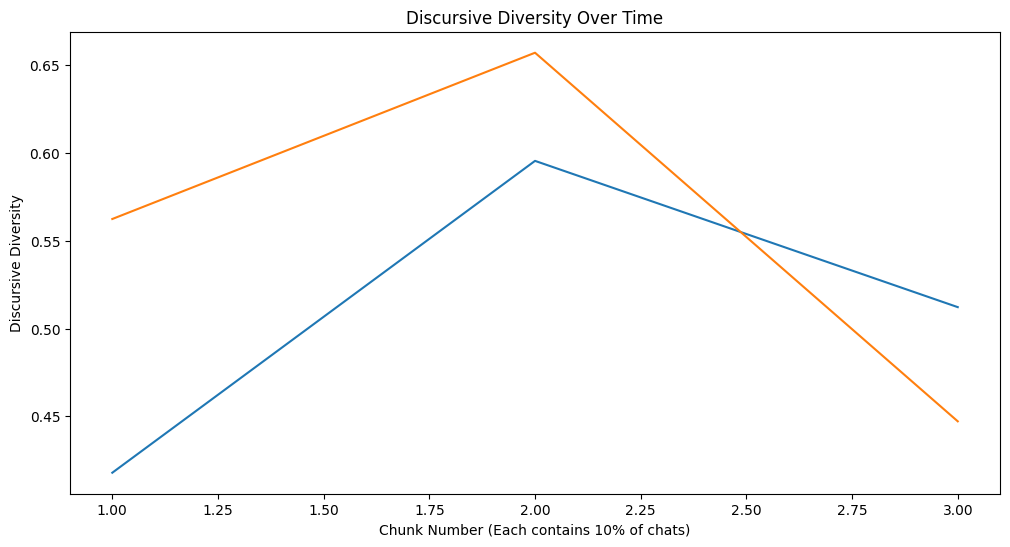

    conversation_num chunk_num
0                  0         0
1                  0         0
2                  0         0
3                  0         0
4                  0         0
5                  0         0
6                  0         0
7                  0         0
8                  0         0
9                  0         0
10                 0         0
11                 0         1
12                 0         1
13                 0         1
14                 0         1
15                 0         1
16                 0         1
17                 0         1
18                 0         1
19                 0         1
20                 0         1
21                 0         1
22                 0         2
23                 0         2
24                 0         2
25                 0         2
26                 0         2
27                 0         2
28                 0         2
29                 0         2
30                 0         2
31      

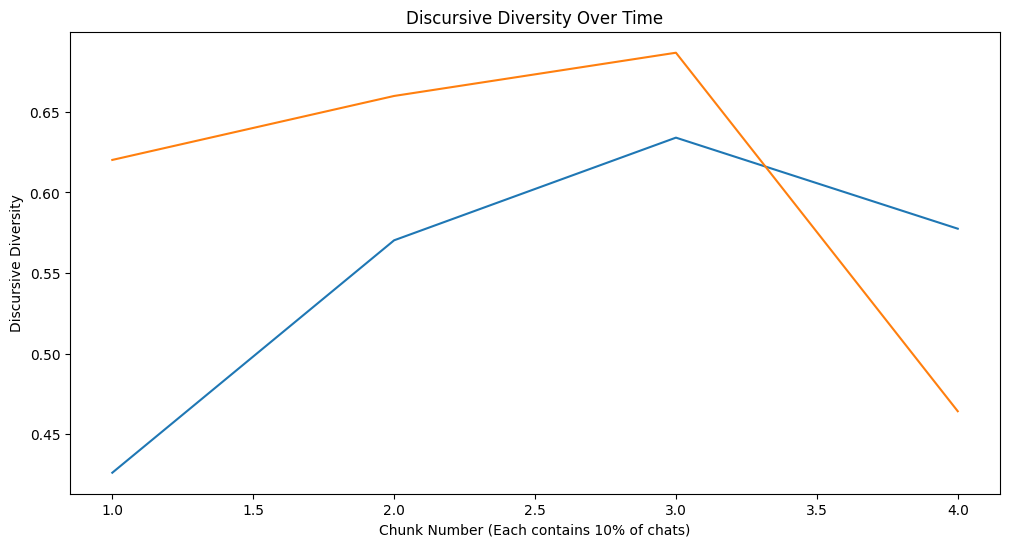

    conversation_num chunk_num
0                  0         0
1                  0         0
2                  0         0
3                  0         0
4                  0         0
5                  0         0
6                  0         0
7                  0         0
8                  0         0
9                  0         1
10                 0         1
11                 0         1
12                 0         1
13                 0         1
14                 0         1
15                 0         1
16                 0         1
17                 0         1
18                 0         2
19                 0         2
20                 0         2
21                 0         2
22                 0         2
23                 0         2
24                 0         2
25                 0         2
26                 0         2
27                 0         3
28                 0         3
29                 0         3
30                 0         3
31      

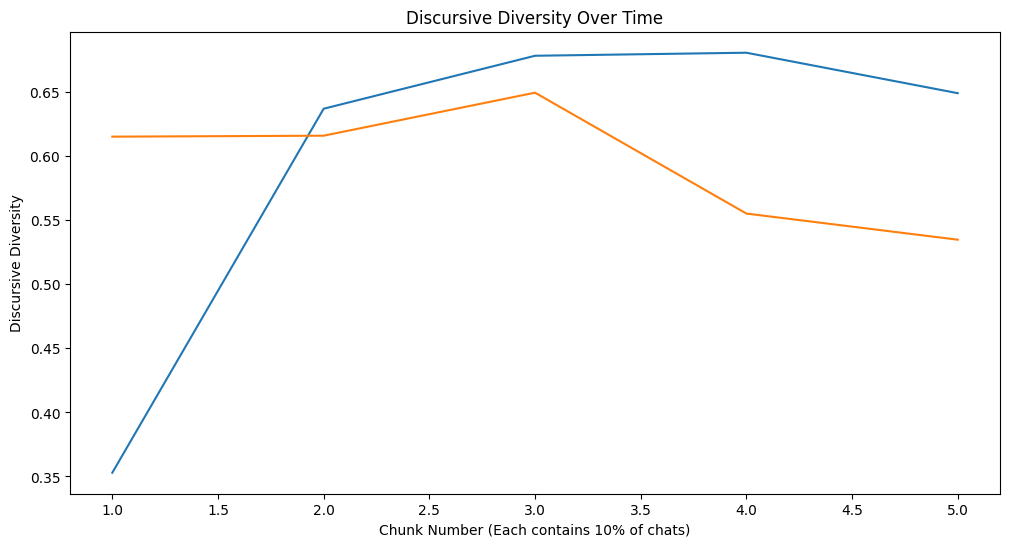

    conversation_num chunk_num
0                  0         0
1                  0         0
2                  0         0
3                  0         0
4                  0         0
5                  0         0
6                  0         0
7                  0         0
8                  0         1
9                  0         1
10                 0         1
11                 0         1
12                 0         1
13                 0         1
14                 0         1
15                 0         1
16                 0         2
17                 0         2
18                 0         2
19                 0         2
20                 0         2
21                 0         2
22                 0         2
23                 0         2
24                 0         3
25                 0         3
26                 0         3
27                 0         3
28                 0         3
29                 0         3
30                 0         3
31      

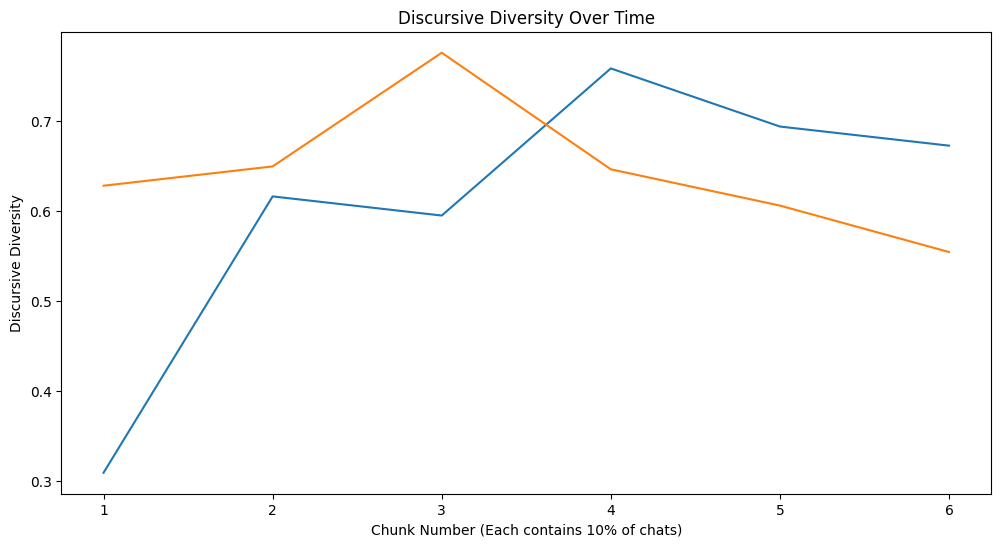

    conversation_num chunk_num
0                  0         0
1                  0         0
2                  0         0
3                  0         0
4                  0         0
5                  0         0
6                  0         0
7                  0         1
8                  0         1
9                  0         1
10                 0         1
11                 0         1
12                 0         1
13                 0         1
14                 0         2
15                 0         2
16                 0         2
17                 0         2
18                 0         2
19                 0         2
20                 0         2
21                 0         3
22                 0         3
23                 0         3
24                 0         3
25                 0         3
26                 0         3
27                 0         3
28                 0         4
29                 0         4
30                 0         4
31      

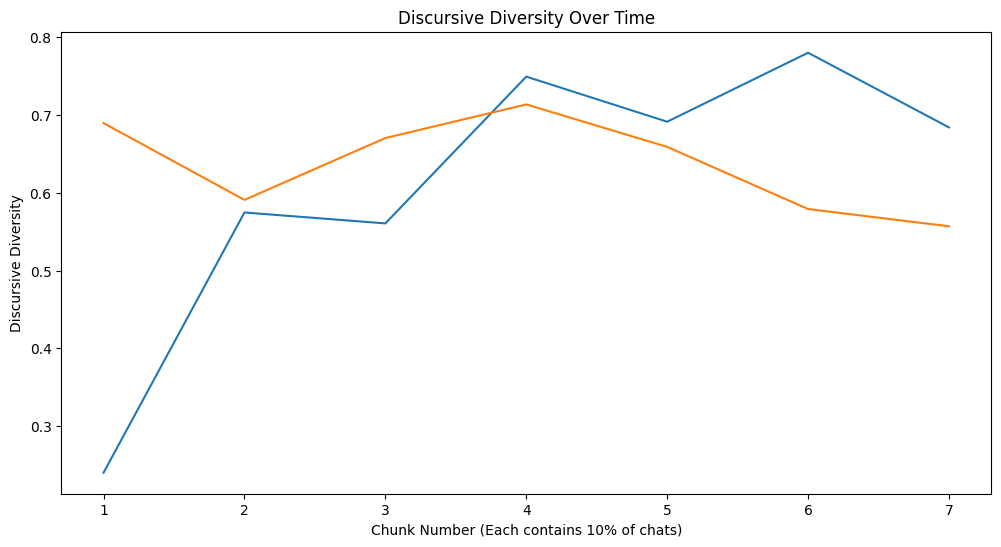

    conversation_num chunk_num
0                  0         0
1                  0         0
2                  0         0
3                  0         0
4                  0         0
5                  0         0
6                  0         1
7                  0         1
8                  0         1
9                  0         1
10                 0         1
11                 0         1
12                 0         2
13                 0         2
14                 0         2
15                 0         2
16                 0         2
17                 0         2
18                 0         3
19                 0         3
20                 0         3
21                 0         3
22                 0         3
23                 0         3
24                 0         4
25                 0         4
26                 0         4
27                 0         4
28                 0         4
29                 0         4
30                 0         5
31      

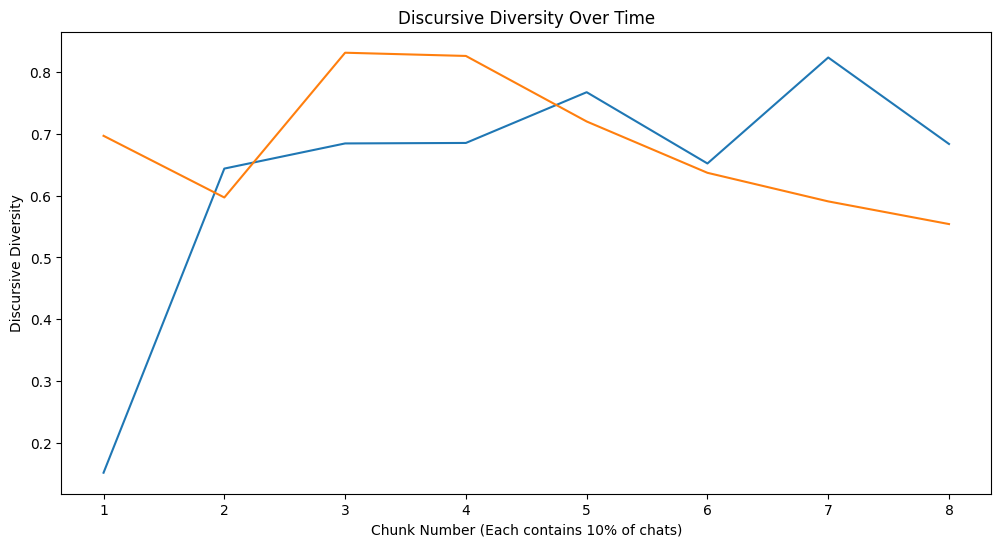

    conversation_num chunk_num
0                  0         0
1                  0         0
2                  0         0
3                  0         0
4                  0         0
5                  0         0
6                  0         1
7                  0         1
8                  0         1
9                  0         1
10                 0         1
11                 0         1
12                 0         2
13                 0         2
14                 0         2
15                 0         2
16                 0         2
17                 0         2
18                 0         3
19                 0         3
20                 0         3
21                 0         3
22                 0         3
23                 0         3
24                 0         4
25                 0         4
26                 0         4
27                 0         4
28                 0         4
29                 0         4
30                 0         5
31      

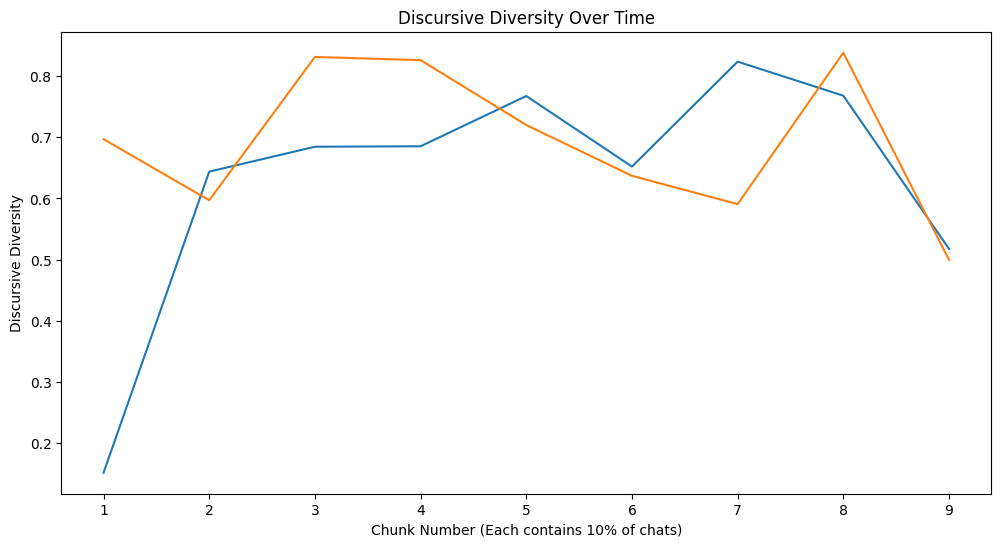

    conversation_num chunk_num
0                  0         0
1                  0         0
2                  0         0
3                  0         0
4                  0         0
5                  0         1
6                  0         1
7                  0         1
8                  0         1
9                  0         1
10                 0         2
11                 0         2
12                 0         2
13                 0         2
14                 0         2
15                 0         3
16                 0         3
17                 0         3
18                 0         3
19                 0         3
20                 0         4
21                 0         4
22                 0         4
23                 0         4
24                 0         4
25                 0         5
26                 0         5
27                 0         5
28                 0         5
29                 0         5
30                 0         6
31      

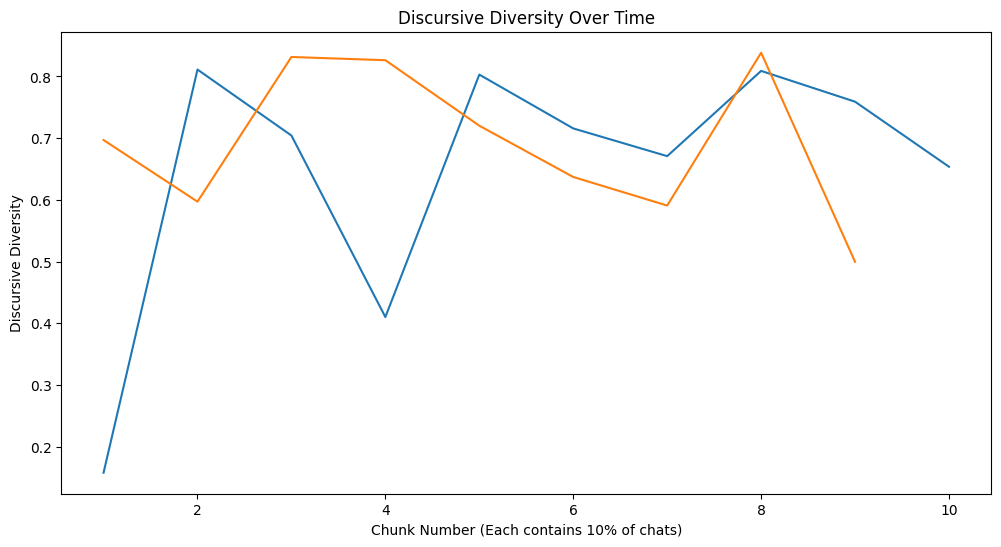

In [13]:
#initialize df array of chunks
juries_chunks = [ [] for i in range (9)]
juries_chunks
chunks_per_conv = 2
for arr in juries_chunks:
    arr = assign_chunk_nums(chat_juries, chunks_per_conv)
    print(arr[["conversation_num", "chunk_num"]].to_string()) # printing to check chunking!
    print("Plot for " + str(chunks_per_conv) + " chunks.")
    plot_dd_results(get_dd_results_by_chunk(arr))
    chunks_per_conv += 1

In [86]:
csop, vcsop = get_and_preprocess_chats("../data/raw_data/csopII_conversations_withblanks.csv", "../embeddings/csopII_conversations_withblanks.csv")
csop['message_embedding'] = conv_to_float_arr(csop['message_embedding'].to_frame())
# csop = assign_chunk_nums(csop, 10)
# csop
# case where max chunks works out, then throw extra into last one 
# csop.loc[csop['conversation_num'] == '25PJSrbtr8mkHTvcw']

Plot for 2 chunks.


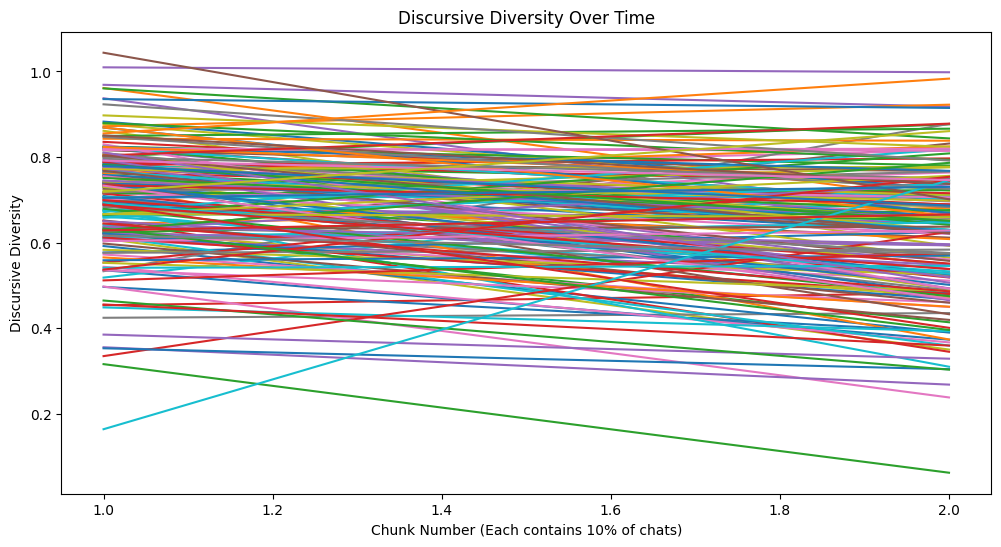

Plot for 3 chunks.


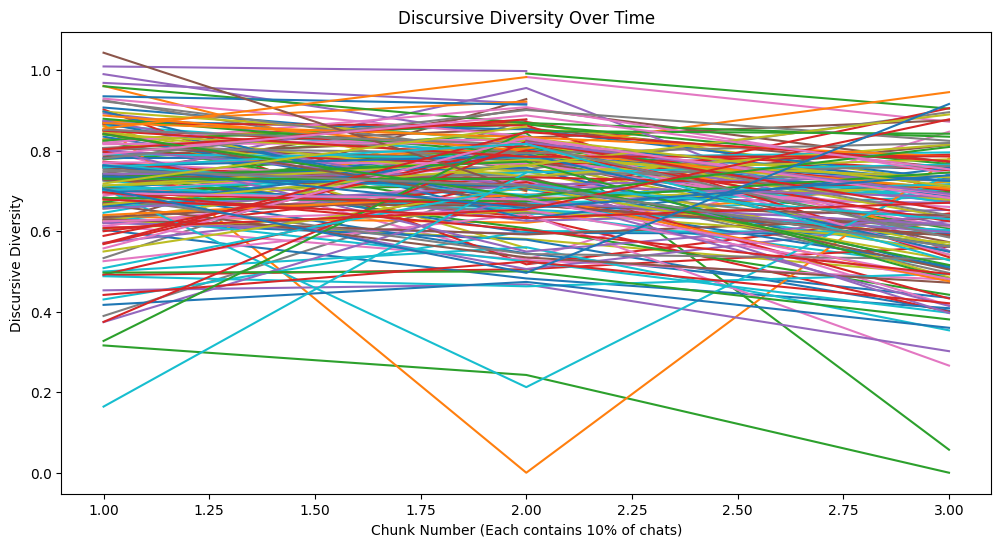

Plot for 4 chunks.


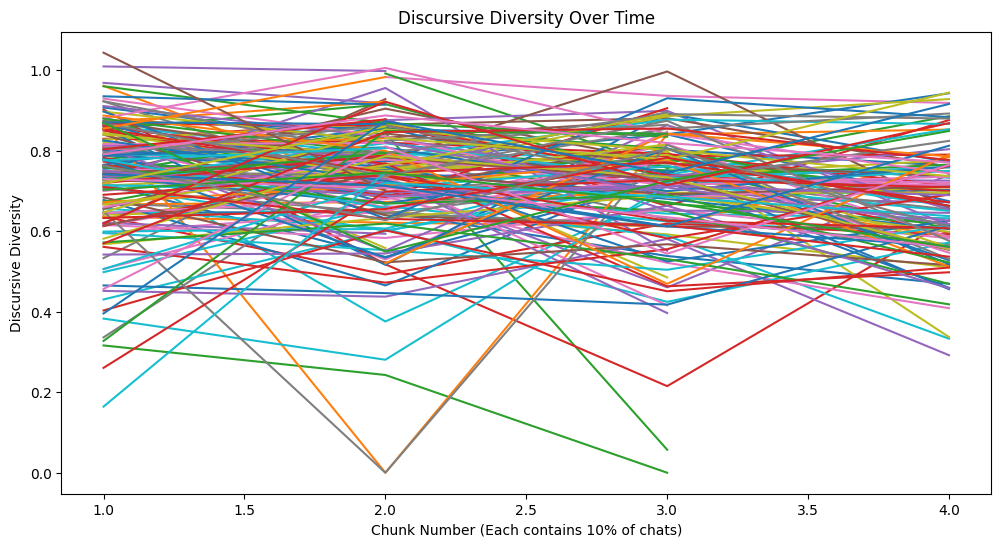

Plot for 5 chunks.


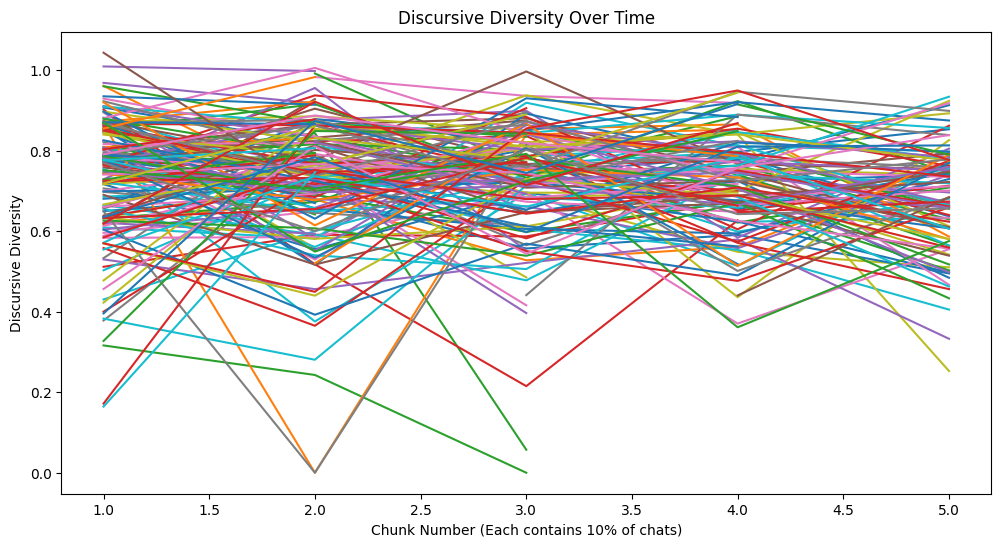

Plot for 6 chunks.


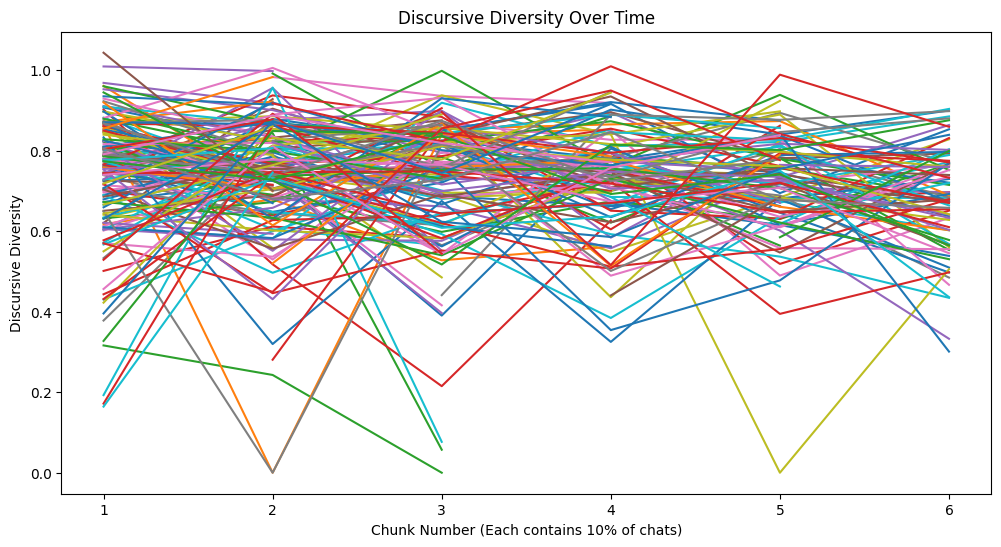

Plot for 7 chunks.


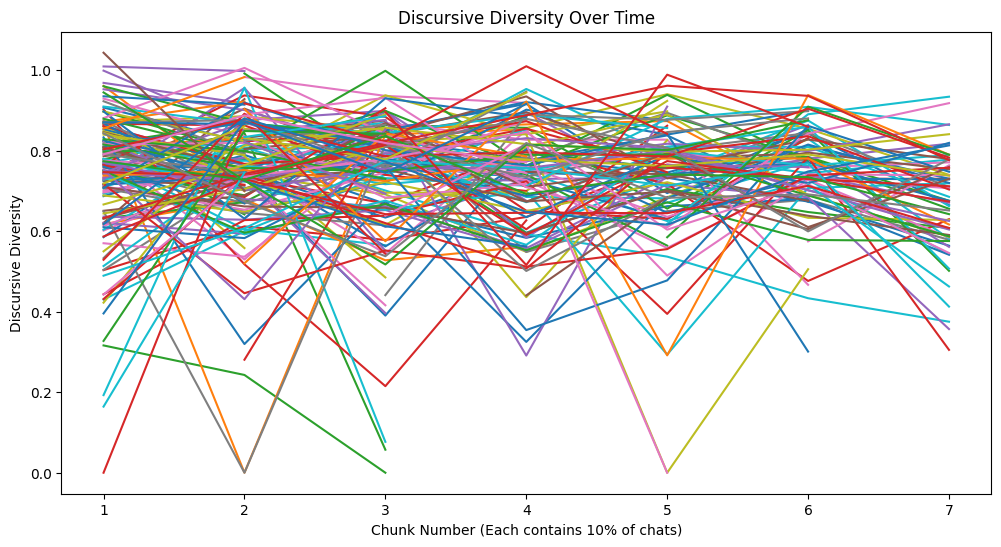

Plot for 8 chunks.


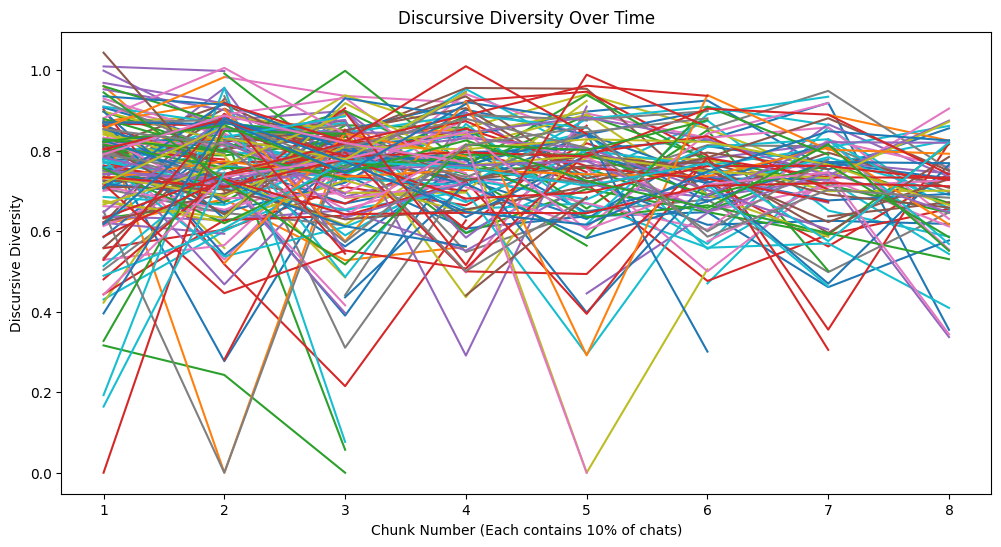

Plot for 9 chunks.


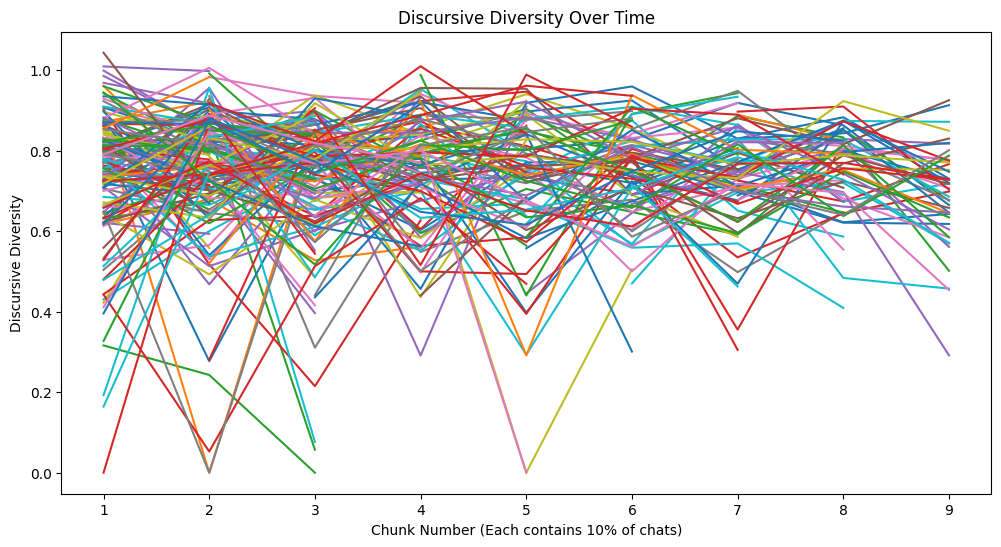

Plot for 10 chunks.


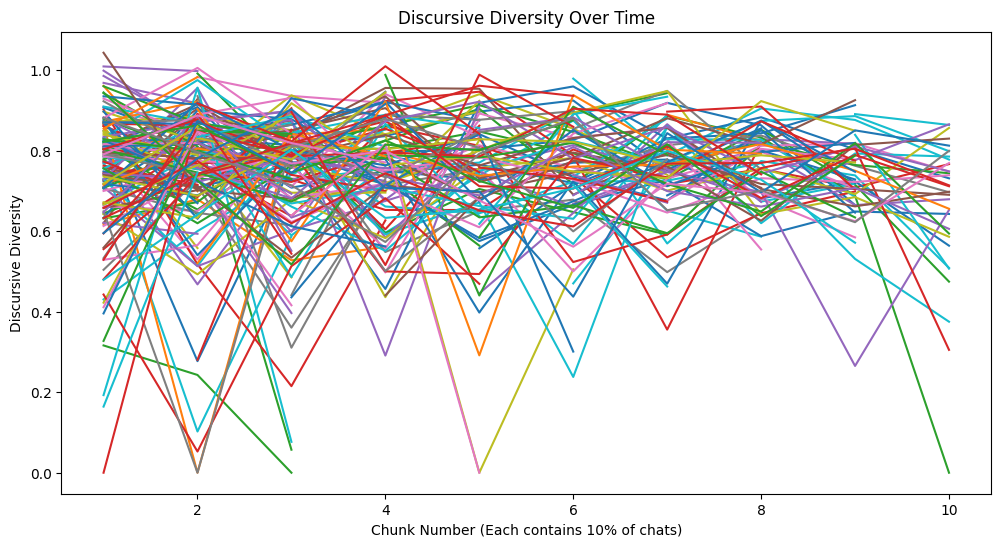

In [87]:
csop_chunks = [ [] for i in range (9)]
csop_chunks
chunks_per_conv = 2
for arr in juries_chunks:
    arr = assign_chunk_nums(csop, chunks_per_conv)
    print("Plot for " + str(chunks_per_conv) + " chunks.")
    plot_dd_results(get_dd_results_by_chunk(arr))
    chunks_per_conv += 1